# Climate Change - Mini Project

<div>
<img src="climate_change.jpg" width="1000" align="center"/>
</div>

In [100]:
import pandas as pd
from tqdm import tqdm
import os
import re
from math import sqrt
import matplotlib.pyplot as plt

from statsmodels.tsa.api import Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [7]:
def load_csv_file(filename):
    try:
        if not os.path.exists(filename):
            print(f"The file: {filename} doesn't exist")
        else:
            print("Found File")
            return pd.concat([chunk for chunk in tqdm(pd.read_csv(filename, chunksize=1000), desc=f'Loading {filename}')])
    except:
        print("Didn't Work! :(")

In [3]:
def rename_columns(df):
    new_names = []

    for column in df.columns:
        level_one = re.sub('(?<!^)(?=[A-Z])', '_', column).lower()
        level_one = re.sub(' ', '_',level_one)
        level_one = re.sub(' _', '_',level_one)
        level_one = re.sub('__','_',level_one)
        new_names.append(level_one)
    df.columns = new_names
    return df

In [4]:
def prepare_df(df):
    print("do stuff")
    
    #return df

# Goal

# Acquire

In [8]:
df = load_csv_file("GlobalLandTemperaturesByCity.csv")

Found File


Loading GlobalLandTemperaturesByCity.csv: 8600it [00:09, 954.90it/s] 


# Explore

In [9]:
# rows & columns in dataframe
df.shape

(8599212, 7)

In [10]:
# columns names
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude'],
      dtype='object')

In [11]:
# list of all the countries in the dataframe
df_countries = sorted(list((df['Country'].unique())))

In [12]:
print(df_countries)

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bolivia', 'Bosnia And Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Congo (Democratic Republic Of The)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Côte D'Ivoire", 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia

# Prepare

In [13]:
# new dataframe of just the US
climate_change_us = df[df['Country'] == 'United States']

In [14]:
climate_change_us.head(1)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W


In [15]:
# rename to cleaner column names
climate_change_us = rename_columns(climate_change_us)

In [16]:
climate_change_us.head(1)

,dt,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W


In [17]:
# renamed column to a more descriptive name
climate_change_us = climate_change_us.rename(columns={'dt':'date'})

In [18]:
# set datetime data type and sort
climate_change_us['date']=pd.to_datetime(climate_change_us['date'])

In [20]:
# set 'date' column as index and sorted
climate_change_us = climate_change_us.set_index("date").sort_index()

In [21]:
climate_change_us.head(1)

,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
date,,,,,,
1743-11-01,1.188,1.531,Boston,United States,42.59N,72.00W


In [22]:
# total amount of cities in dataframe
climate_change_us['city'].unique().shape[0]

248

### Resample

In [30]:
# resampling daily data into monthly data
df_resampled = pd.DataFrame(climate_change_us.resample('M')['average_temperature'].mean())

### Nulls

In [33]:
# filling nulls;whole months in data were Null
df_resampled = df_resampled.interpolate(method='nearest')

### Split

In [43]:
# working dataframe size
df_resampled.shape

(3239, 1)

In [44]:
# split settings
train_size = int(round(df_resampled.shape[0] * 0.5))
validate_size = int(round(df_resampled.shape[0] * 0.3))
test_size = (df_resampled.shape[0]) - (train_size+validate_size)

# verify split size settings
len(df_resampled) == train_size + validate_size + test_size

# split settings index
validate_end_index = train_size + validate_size

In [45]:
# splitting
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [46]:
train.shape[0], validate.shape[0], test.shape[0]

(1620, 972, 647)

In [47]:
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [56]:
train['average_temperature'].min(),train['average_temperature'].max()

(-5.348571428571428, 29.88291836734694)

In [70]:
train.index.year.min(),train.index.year.max()

(1743, 1878)

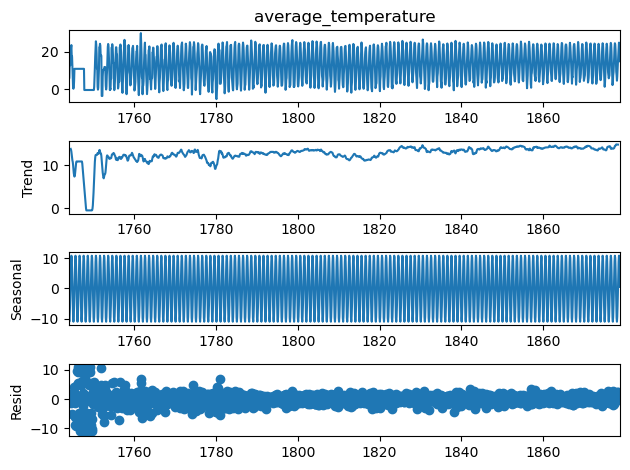

In [62]:
decompose_result = seasonal_decompose(train['average_temperature'],model='additive')
decompose_result.plot();

# Modeling

### Holt's Exponential Smoothing

#### Fit

In [72]:
# Models for quantity
hst_quantity_fit1 = ExponentialSmoothing(train['average_temperature'], seasonal_periods=12, trend='add', seasonal='add').fit()
#hst_quantity_fit2 = ExponentialSmoothing(train['average_temperature'], seasonal_periods=12, trend='add', seasonal='mul').fit()
hst_quantity_fit3 = ExponentialSmoothing(train['average_temperature'], seasonal_periods=12, trend='add', seasonal='add', damped_trend=True).fit()
#hst_quantity_fit4 = ExponentialSmoothing(train['average_temperature'], seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()

### Metric Results

In [73]:
results_quantity=pd.DataFrame({'model':['hst_quantity_fit1','hst_quantity_fit3'],
                              'SSE':[hst_quantity_fit1.sse, hst_quantity_fit3.sse]})
results_quantity

,model,SSE
0,hst_quantity_fit1,6147.106463
1,hst_quantity_fit3,6145.450054


In [74]:
results_quantity.sort_values(by='SSE')

,model,SSE
1,hst_quantity_fit3,6145.450054
0,hst_quantity_fit1,6147.106463


### Predict

In [110]:
yhat_df = pd.DataFrame({'average_temperature': hst_quantity_fit3.forecast(validate.shape[0])},index = validate.index)
yhat_df

,average_temperature
date,
1878-11-30,9.278409
1878-12-31,5.102071
1879-01-31,3.846018
1879-02-28,5.612998
1879-03-31,8.460410
...,...
1959-06-30,22.119992
1959-07-31,24.448121
1959-08-31,23.753146


In [111]:
pred = hst_quantity_fit1.forecast(steps=12)

In [83]:
pred.head()

1878-11-30    9.278767
1878-12-31    5.102383
1879-01-31    3.846966
1879-02-28    5.614616
1879-03-31    8.462913
Freq: M, dtype: float64

### Evaluate

In [85]:
# 
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [97]:
# 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [98]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [102]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [112]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_15094/1340801264.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


average_temperature -- RMSE: 1


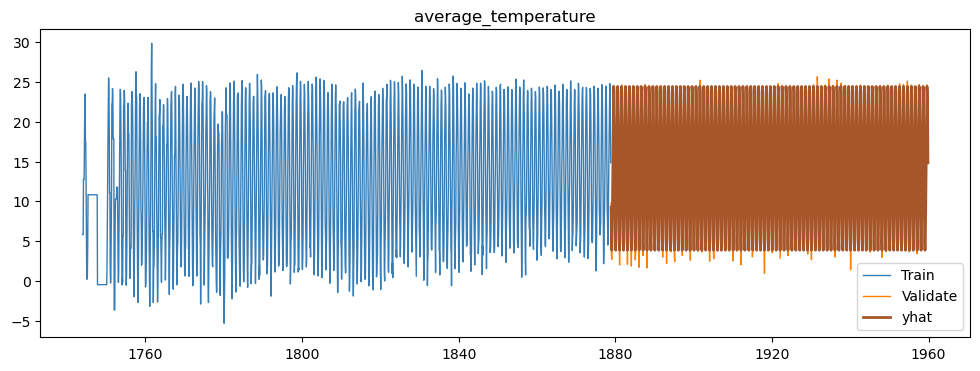

,model_type,target_var,rmse
0,holts_seasonal_add_add,average_temperature,1.0
1,holts_seasonal_add_add,average_temperature,1.0
2,holts_seasonal_add_add,average_temperature,1.0


In [114]:
for col in train.columns:
    plot_and_eval(col)
eval_df

In [ ]:
def model_evaluator_tracker(model_name,target_name,pred,validate):
    '''
    This function creates an empty dataframe, utilizes evaluate() function,
    saves RMSE metrics based on target variable. Provide "model_name","target_name",
    prediction DataFrame, and validate DataFrame
    '''
    rmse = evaluate(target_name)
    temp_df = {'model_type': [model_name], 'target_var': [target_name],
        'rmse': [rmse]}
    temp_df = pd.DataFrame(temp_df)
    
    print(temp_df)

In [ ]:
class DataFrameUpdater:
    def __init__(self):
        self.df = pd.DataFrame(columns=['Column 1', 'Column 2'])

    def update_df(self, data):
        self.df = self.df.append(data, ignore_index=True)
        return self.df
# main()
# ============================

df_updater = DataFrameUpdater()
data_dict = {'Column 1': [1], 'Column 2': [2]}

# test 1
df = df_updater.update_df(data_dict)
print(df)

# test 2
data = {'Column 1': [3], 'Column 2': [4]}
df = df_updater.update_df(data)

print(df)

# Test

In [126]:
yhat_df = pd.DataFrame({'average_temperature': hst_quantity_fit3.forecast(validate.shape[0] + test.shape[0])})
yhat_df

,average_temperature
1878-11-30,9.278409
1878-12-31,5.102071
1879-01-31,3.846018
1879-02-28,5.612998
1879-03-31,8.460410
...,...
2013-05-31,17.630038
2013-06-30,22.119992
2013-07-31,24.448121
2013-08-31,23.753146


In [127]:
test.head(1)

,average_temperature
date,
1959-11-30,9.393284


In [133]:
test.index.max()

Timestamp('2013-09-30 00:00:00', freq='M')

In [128]:
# Test Predictions
yhat_df = yhat_df['1959-11-30':]

In [129]:
yhat_df.shape

(647, 1)

In [130]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [131]:
rmse_average_temperature = sqrt(mean_squared_error(test['average_temperature'], 
                                       yhat_df['average_temperature']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-rmse_average_temperature:  1.167780863916205


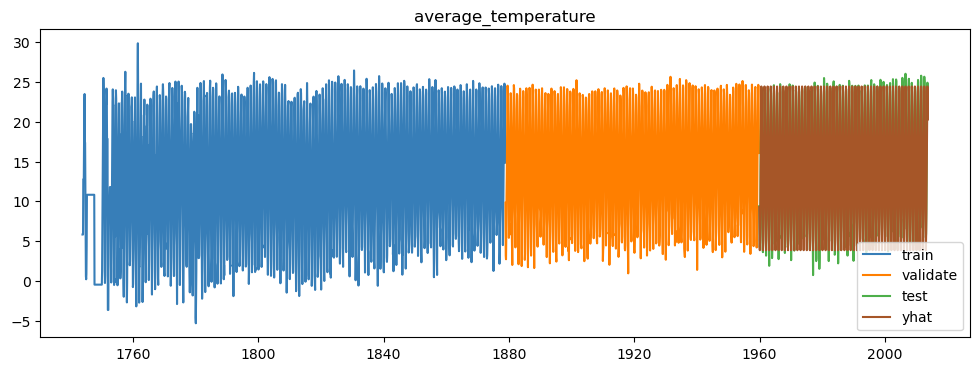

In [132]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-average_temperature: ', rmse_average_temperature)
for col in train.columns:
    final_plot(col)

# Forecast

In [135]:
forecast = pd.DataFrame({'average_temperature': hst_quantity_fit3.forecast(validate.shape[0] + test.shape[0] + 365)})
forecast = forecast['2014':]
forecast

,average_temperature
2014-01-31,3.846018
2014-02-28,5.612998
2014-03-31,8.460410
2014-04-30,12.724230
2014-05-31,17.630038
...,...
2043-10-31,14.847980
2043-11-30,9.278409
2043-12-31,5.102071
2044-01-31,3.846018


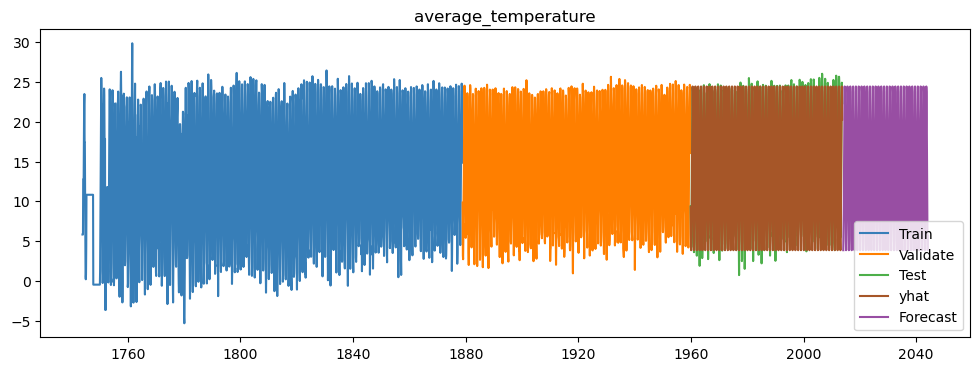

In [136]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()
for col in train.columns:
    final_plot(col)

In [137]:
def data_dictionary(df):
    # Printing a data dictionary using a printout of each column name
    # formatted as a MarkDown table
    # =================================================================

    # variable to hold size of longest string in dataframe column names
    size_longest_name = len((max((df.columns.to_list()), key = len)))

    # head of markdown table
    print(f"| {'Name' : <{size_longest_name}} | Definition |")
    print(f"| {'-'*size_longest_name} | {'-'*len('Definition')} |")

    # dataframe column content
    for i in (df.columns.to_list()):
        print(f"| {i : <{size_longest_name}} | Definition |")

In [138]:
data_dictionary(climate_change_us)

| Name                            | Definition |
| ------------------------------- | ---------- |
| average_temperature             | Definition |
| average_temperature_uncertainty | Definition |
| city                            | Definition |
| country                         | Definition |
| latitude                        | Definition |
| longitude                       | Definition |
